# **13E054VI Veštačka inteligencija**

**Drugi domaći zadatak**  
student: Aleksandra Ljubenović 2020/0117

# Zadatak 1

U ovom zadatku bilo je potrebno konstruisati aciklični usmereni graf koji odgovara Bayes-ovoj mreži definisanoj zadatim tabelama uslovnih verovatnoća (TUV), a potom odrediti uslovnu verovatnoću P(c+|f+,g+) primenom sledeće 3 metode:

- Metod eliminacije (računanje tačne vrednosti)
- Uzorkovanje sa odbacivanjem (jedna aproksimacija iz uzorka)
- Gibbsovo uzorkovanje (druga aproksimacija iz uzorka)

<u>Metod eliminacije</u>

Na sledećim slikama prikazan je aciklični usmereni graf koji odgovara problemu definisanom tekstom zadatka, kao i postupak za računanje uslovne verovatnoće P(c+|f+,g+) primenom metode eliminacije. Dobijena je vrednost P(c+|f+,g+) = 0.3631364, koja će u nastavku biti smatrana teorijski tačnom vrednošću.

<img src="VI_dz2_z1a_1.jpeg" style="width: 50%;">
<img src="VI_dz2_z1a_2.jpeg" style="width: 50%;">

<u>Uzorkovanje sa odbacivanjem</u>

Prilikom aproksimacije verovatnoće P(c+|f+,g+) uzorkovanjem sa odbacivanjem, generisan je uzorak veličine N = 10 000 odbiraka, a tražena uslovna verovatnoća aproksimirana je količnikom broja elemenata uzorka za koji važi c = c+, f = f+ i g = g+ i broja elemenata uzorka za koji važi f = f+ i g = g+ (brojilac je jednak ukupnom broju elemenata u uzorku jer se uzorkovanje radi sa odbacivanjem). Odbirci promenljivih a, b, c, e, f i g generisani su na osnovu raspodela P(a-), P(b-|a), P(c-|a), P(e-|b,c), P(f-|e) i P(g-|e), respektivno. Odbirci promenljive d nisu generisani jer je ona "nebitna" promenljiva, tj. nije predak ni upitne ni dokaznih promenljivih.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

N = 50000     # veličina uzorka
Nr = 100    # broj ponavljanja procedure

# Tabele (uslovnih) verovatnoća

p_a = np.array([0.6, 0.4])                                    # (a)
p_b = np.array([[0.7,0.3],[0.2,0.8]])                         # (a,b)                 
p_c = np.array([[0.7,0.3],[0.3,0.7]])                         # (a,c)
p_e = np.array([[[0.1,0.9],[0.5,0.5]],[[0.2,0.8],[0.8,0.2]]]) # (b,c,e)
p_f = np.array([[0.4,0.6],[0.6,0.4]])                         # (e,f)
p_g = np.array([[0.8,0.2],[0.3,0.7]])                         # (e,g)

# Estimacija uslovne verovatnoće p(c+|f+,g+)

p_arr_1 = np.zeros((Nr))

for i in range(Nr):

    S = 0
    n_samples = 0
    
    while(n_samples < N):
        
        # Uzorkovanje promenljivih
        # a
        a = 0 if random.random() <= p_a[0] else 1
        # b
        b = 0 if random.random() <= p_b[a,0] else 1
        # c
        c = 0 if random.random() <= p_c[a,0] else 1
        # e
        e = 0 if random.random() <= p_e[b,c,0] else 1
        # f
        if random.random() <= p_f[e,0]:   # odbacivanje! (f = f-)
            continue
        else:   # f = f+
            # g
            if random.random() <= p_g[e,0]:   # odbacivanje! (g = g-)
                continue
            else:   # g = g+
                n_samples += 1

                if c == 1:  # c = c+
                    S += 1        
    
    # Estimacija tražene verovatnoće za jedan uzorak
    p_est = S/N
    p_arr_1[i] = p_est

p_mean_1 = np.mean(p_arr_1)
p_std_1 = np.std(p_arr_1)


<u>Gibsovo uzorkovanje</u>

U slučaju Gibbsovog uzorkovanja, veličina uzorka je ponovo N = 10 000 odbiraka. Odbirci promenljive d ponovo nisu uzorkovani jer je ona "nebitna" promenljiva. Dodatno, nisu generisani ni odbirci promenljivih f i g, jer oni sve vreme imaju konstantnu vrednost (f = f+ i g = g+). Odbirci promenljivih a, b, c i e uzorkovani su na osnovu uslovnih raspodela p(A|MP(A)) ~ p(B|A)p(C|A)p(A), p(B|MP(B)) ~ p(E|B,C)p(B|A), p(C|MP(C)) ~ p(E|B,C)p(C|A) i p(E|MP(E)) ~ p(f+|E)p(g+|E)p(E|B,C), respektivno. Ugorevanje (problem koji je posledica činjenice da generisani odbirci u početku nemaju nemaju željenu raspodelu) sprečen je tako što prvih 100 odbiraka nije uzimano u obzir prilikom aproksimacije verovatnoće P(c+|f+,g+). 

In [139]:
p_arr_2 = np.zeros((Nr))

for i in range(Nr):

    # Inicijalizacija promenljivih
    (a,b,c,e) = tuple([int(random.random()//0.5) for _ in range(4)])    # nasumična inicijalizacija
    f = 1
    g = 1

    # Generisanje uzorka
    N_skip = 100
    S = 0
    for j in range(N):
        
        # A ~ p(A|MP(A)) ~ p(B|A)p(C|A)p(A)
        tmp = random.random()
        p_tmp = p_b[0,b]*p_c[0,c]*p_a[0] / (p_b[0,b]*p_c[0,c]*p_a[0] + p_b[1,b]*p_c[1,c]*p_a[1])
        a = 0 if tmp <= p_tmp else 1

        # B ~ p(B|MP(B)) ~ p(E|B,C)p(B|A)
        tmp = random.random()
        p_tmp = p_e[0,c,e]*p_b[a,0] / (p_e[0,c,e]*p_b[a,0] + p_e[1,c,e]*p_b[a,1])
        b = 0 if tmp <= p_tmp else 1

        # C ~ p(C|MP(C)) ~ p(E|B,C)p(C|A)
        tmp = random.random()
        p_tmp = p_e[b,0,e]*p_c[a,0] / (p_e[b,0,e]*p_c[a,0] + p_e[b,1,e]*p_c[a,1])
        if tmp <= p_tmp:
            c = 0
        else:
            c = 1
            if j >= N_skip:
                S += 1

        # E ~ p(E|MP(E)) ~ p(f+|E)p(g+|E)p(E|B,C)
        tmp = random.random()
        p_tmp = p_f[0,f]*p_g[0,g]*p_e[b,c,0] / (p_f[0,f]*p_g[0,g]*p_e[b,c,0] + p_f[1,f]*p_g[1,g]*p_e[b,c,1])
        e = 0 if tmp <= p_tmp else 1

    # Estimacija tražene verovatnoće za jedan uzorak
    p_est = S/(N-N_skip)
    p_arr_2[i] = p_est
        
p_mean_2 = np.mean(p_arr_2)
p_std_2 = np.std(p_arr_2)


<u>Prikaz rezultata</u>

Na sledećim graficima prikazani su histogrami estimiranih uslovnih verovatnoća P(c+|g+,f+) za slučaj uzorkovanja sa odbacivanjem i Gibbsovog uzorkovanja, dobijeni nakon Nr = 100 ponavljanja svake od procedura. Na samim graficima prikazane su i srednje vrednosti i standardne devijacije ovih procena. Na osnovu prikazanih rezultata može se zaključiti da je odabrana dovoljno velika veličina uzorka N, jer su standardne devijacije i u slučaju uzorkovanja sa odbacivanjem i u slučaju Gibbsovog uzorkovanja približno jednake i jako male vrednosti.

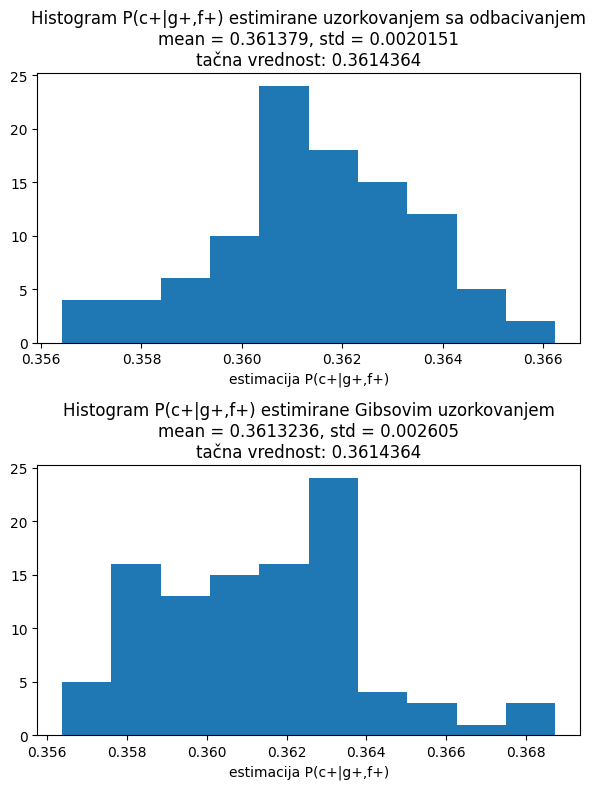

In [148]:
plt.figure(figsize=(6,8))
plt.subplot(2,1,1)
plt.hist(p_arr_1,bins = round(np.sqrt(Nr)))
plt.xlabel("estimacija P(c+|g+,f+)")
plt.title("Histogram P(c+|g+,f+) estimirane uzorkovanjem sa odbacivanjem\n"
            "mean = {}, std = {}\n"
                "tačna vrednost: 0.3614364".format(round(p_mean_1,7),round(p_std_1,7)));
plt.subplot(2,1,2)
plt.hist(p_arr_2,bins = round(np.sqrt(Nr)))
plt.xlabel("estimacija P(c+|g+,f+)")
plt.title("Histogram P(c+|g+,f+) estimirane Gibsovim uzorkovanjem\n"
            "mean = {}, std = {}\n"
                "tačna vrednost: 0.3614364".format(round(p_mean_2,7),round(p_std_2,7)));
plt.tight_layout()

# Zadatak 2

U ovom zadatku bilo je potrbno konstruisati čestični filtar za estimaciju modela kretanja robota na osnovu dostupnih zašumljenih merenja rastojanja ($\rho$) i ugla pod kojim se robot nalazi u odnosu na mernu stanicu ($\theta$).

Konstruisan je čestični filtar od N = 1 000 čestica. 

<u>Inicijalizacija</u>

Inicijalizacija filtra izvršena je tako što su x i y koordinate pozicije inicijalizovane kao uniformno raspodeljenje slučajne promenljive na intervalu [-2, 2] m, dok su početni pravci kretanja čestica (ugao $\alpha$) inicijalizovani kao slučajne promenljive sa uniformnom raspodelom na intervalu [0, 2*$\pi$] rad. Inicijalna vrednost svih težina čestica je jednaka i iznosi 1/N.

Svaka iteracija čestičnog filtra sastoji se iz sledećih koraka:
- predikcija
- opservacija
- estimacija
- reuzorkovanje

Svaki od ovih koraka opisan je u nastavku.

<u>Predikcija</u>

Predikcije x i y koordinati pozicije i ugla $\alpha$ izvršene su na osnovu definisanog modela kretanja. Najpre je, u skladu sa verovatnoćom promene pravca kretanja čestice (koja zavisi od trenutka poslednje promene pravca te čestice), promenjen ugao $\alpha$ za inkrement koji predstavlja uniformno raspodeljenju slučajnu promenljivu na intervalu [-$\pi$/6, $\pi$/6], a zatim je pozicija čestice ažurirana tako što je na x koordinatu dodat inkrement v\*cos($\alpha$)\*T, a na y koordinatu inkrement v\*sin($\alpha$)\*T (v = 0.5 m/s, T = 1 s).

<u>Opservacija</u>

Na osnovu dostupnih merenja, u svakoj iteraciji su ažurirane težine čestica. Kako težine čestica predstavljaju verodostojnosti zabeleženih dokaza, ažuriranje težina je izvršeno tako što je trenutna težina čestice pomnožena verodostojnostima merenja rastojanja i ugla robota u odnosu na mernu stanicu. Pri tome, u slučaju merenja rastojanja, šum merenja je normalno raspodeljen, a njegova standardna devijacija je izračunata za svaku od čestica pojedinačno, na osnovu razlike uglova koji odgovaraju pravcu kretanja čestice $\alpha$ i njenog ugla u odnosu na x-osu $\theta$. U slučaju merenja ugla $\theta$, šum merenja ima Laplasovu laspodelu sa konstantnom standardnom devijacijom koja iznosi $\pi$/36. Obe raspodele imaju srednju vrednost 0. Nakon ažuriranja težina svih čestica, težine su normalizovane tako da njihov zbir bude jednak 1.

<u>Estimacija</u>

Estimacija pozicije robota u razmatranim diskretnim trenucima vremena izvršena je tako što je x koordinata estimirana kao suma x koordinati svih čestica, otežinjenih težinama tih česticama, što aproksimira nalaženje očekivanja (analogno je estimirana i y koordinata).

<u>Reuzorkovanje</u>

Da bi se sprečila degradacija težina čestica, na kraju svake iteracije vršeno je reuzorkovanje čestica, tako što je od svih N čestica slučajno odabrano N čestica (sa ponavljanjem), pri čemu je verovatnoća da neka čestica bude odabrana proporcionalna težini te čestice. Ovime će biti sprečeno da "najteže" čestice vremenom pokupe svu težinu, ali će ipak biti obezveđeno da se, nakon reuzorkovanja, čestice koje su bile teže u novom uzorku javljaju česće.

Kako reuzorkovanje može da dovede do osiromašenja uzorka (gubljenja njegove raznolikosti), na x i y koordinate čestica nakon reuzorkovanja dodavan je normalno raspodeljen šum srednje vrednosti 0 i standardne devijacije 0.2 m. Dodatno, nakon reuzorkovanja, težine svih čestica reinicijalizovane su na 1/N.

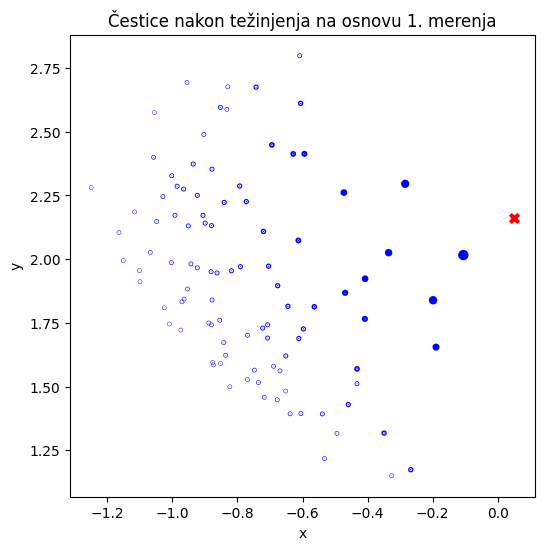

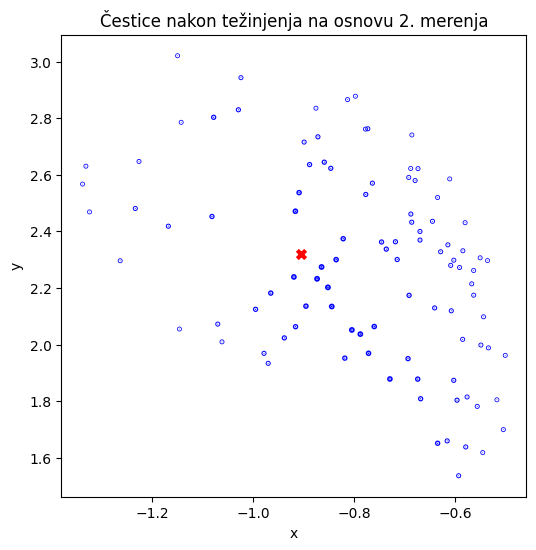

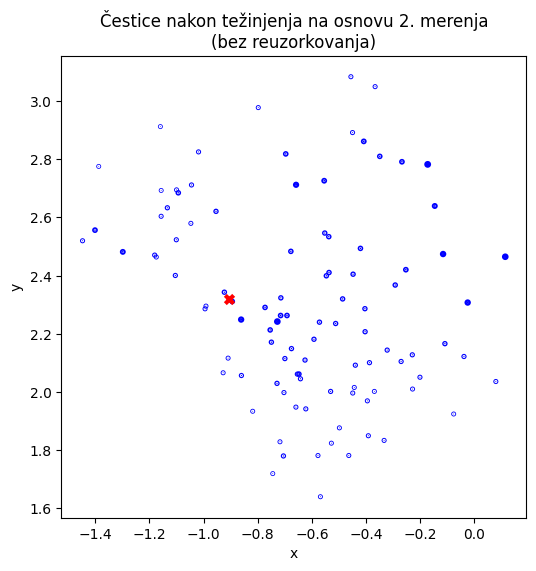

In [9]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

### Učitavanje opservacija

def read_data(path):

    data = np.array(pd.read_csv(path, header=None))
    rho = data[:,0]     # m
    theta = data[:,1]   # rad
    N_o = len(rho)  # broj opservacija

    return (rho, theta, N_o)

### Inicijalizacija početnih vrednosti

def initialization(N):

    x_init = np.random.uniform(low=-2, high=2, size=N)  # početna pozicija po x osi
    y_init = np.random.uniform(low=-2, high=2, size=N)  # početna pozicija po y osi
    alpha_init = np.random.uniform(low=0, high=2*np.pi, size=N) # početni pravac kretanja

    particles = np.array([x_init, y_init, alpha_init])  # 3 x N
    weights = 1/N*np.ones((N))

    return (particles, weights)

### Model kretanja

def motion_model(particles, v, T, p_turning):

    x = particles[0,:]
    y = particles[1,:]
    alpha = particles[2,:]

    # ažuriranje pravca kretanja
    for i in range(len(x)):

        if random.random() <= p_turning[i]:
            alpha[i] += np.random.uniform(low=-np.pi/6, high=np.pi/6)
            alpha[i] = np.mod(alpha[i], 2*np.pi)
            p_turning[i] = 0.2
        else:
            p_turning[i] += 0.2

        # ažuriranje pozicije
        x[i] += v*np.cos(alpha[i])*T
        y[i] += v*np.sin(alpha[i])*T

    particles[0,:] = x
    particles[1,:] = y
    particles[2,:] = alpha

    return particles

### Model merenja

def sigma_rho(theta, alpha):

    sigma_rho_t = 0.3
    sigma_rho_n = 0.6
    k = (sigma_rho_n-sigma_rho_t)/(np.pi/2)

    theta = np.mod(theta, 2*np.pi)
    alpha = np.mod(alpha, 2*np.pi)

    angle = alpha - theta
    angle = np.mod(angle, 2*np.pi)

    if (np.pi/2 <= angle) and (angle <= np.pi):
        angle = np.pi - angle
    elif (np.pi <= angle) and (angle <= 3*np.pi/2):
        angle = angle - np.pi
    elif (3*np.pi/2 <= angle) and (angle <= 2*np.pi):
        angle = 2*np.pi - angle

    sigma_rho = sigma_rho_t + k*angle

    return sigma_rho

### Ažuriranje težina na osnovu opservacija

def weights_update(particles, weights, rho, theta):

    x = particles[0,:]
    y = particles[1,:]
    alpha = particles[2,:]

    for i in range(len(x)):

        rho_tmp = np.sqrt(x[i]**2 + y[i]**2)
        theta_tmp = np.mod(np.arctan2(y[i], x[i]), 2*np.pi)

        sigma_rho_tmp = sigma_rho(theta, alpha[i])
        sigma_theta = np.pi/36

        weight_rho = np.exp(-0.5*((rho_tmp-rho)/sigma_rho_tmp)**2 / (np.sqrt(2*np.pi)*sigma_rho_tmp)) # normalna raspodela
        weight_theta = np.exp(-np.abs(theta_tmp-theta)/sigma_theta) / (2*sigma_theta)   # Laplasova raspodela
        weights[i] *= weight_rho*weight_theta

    weights /= np.sum(weights)  # normalizacija težina tako da zbir bude 1

    return weights

### Estimacija pozicije

def estimation(particles, weights):

    x = particles[0,:]
    y = particles[1,:]

    x_est = np.sum(x*weights)
    y_est = np.sum(y*weights)

    rho_est = np.sqrt(x_est**2 + y_est**2)
    rho_std = np.std(np.sqrt(x**2 + y**2))

    theta_est = np.mod(np.arctan2(y_est, x_est), 2*np.pi)
    theta_std = np.std(np.mod(np.arctan2(y, x), 2*np.pi))

    return (x_est, y_est, rho_est, theta_est, rho_std, theta_std)

### Reuzorkovanje čestica

def resampling(particles, weights):

    N = len(weights)

    indices = np.random.choice(a=range(N), p=weights, size=N, replace=True)
    particles = particles[:,indices]
    weights = 1/N*np.ones((N))

    # unošenje perturbacije kako bi se umanjilo osiromašenje uzorka
    particles[:2,:] = particles[:2,:] + np.random.normal(loc=0, scale=0.2, size=(2,N))

    return (particles, weights)

# Prikaz čestica
def plot_particles(particles, weights, iter, rho, theta, str=""):

    N_best = 100

    sorted_weights_indices = np.argsort(weights)[::-1]
    top_indices = sorted_weights_indices[:N_best]

    top_particles = particles[:,top_indices]
    top_weights = weights[top_indices]

    plt.figure(figsize=(6,6))
    plt.scatter(top_particles[0,:], top_particles[1,:], s=top_weights*100, linewidths=3, alpha=1, c='b')
    plt.scatter(rho*np.cos(theta), rho*np.sin(theta), marker='x', c='r', linewidths=3)
    plt.xlabel('x'); plt.ylabel('y')
    plt.title("Čestice nakon težinjenja na osnovu {}. merenja".format(iter)+str)

    return

### Čestični filtar

(rho, theta, N_o) = read_data("observations.csv")   # merenja

T = 1   # s
t = range(0, N_o*T, T)  # vremenska osa
v = 0.5 # m/s

N = 1000    # broj čestica

p_turning = 0.2*np.ones((N))
rho_est = np.zeros((N_o))
rho_std = np.zeros((N_o))
theta_est = np.zeros((N_o))
theta_std = np.zeros((N_o))
est_trajectory = np.zeros((2,N_o))

# Inicijalizacija
(particles, weights) = initialization(N)

for i in range(N_o):

    # Predikcija
    particles = motion_model(particles, v, T, p_turning)

    if i == 2:
        particles_old = motion_model(particles_old, v, T, p_turning)

    # Opservacija
    weights = weights_update(particles, weights, rho[i], theta[i])

    if i == 1:
        plot_particles(particles, weights, i, rho[i], theta[i])

    elif i == 2:

        weights_old = weights_update(particles_old, weights_old, rho[i], theta[i])
        plot_particles(particles, weights, i, rho[i], theta[i])
        plot_particles(particles_old, weights_old, i, rho[i], theta[i], "\n(bez reuzorkovanja)")

    # Estimacija
    (x_est, y_est, rho_est[i], theta_est[i], rho_std[i], theta_std[i]) = estimation(particles, weights)
    est_trajectory[:,i] = (x_est, y_est)

    # Reuzorkovanje
    if i==1:
        # za prikaz bez reuzorkovanja
        particles_old = particles
        weights_old = weights

    (particles, weights) = resampling(particles, weights)


<u>Grafički prikaz rezultata<u>

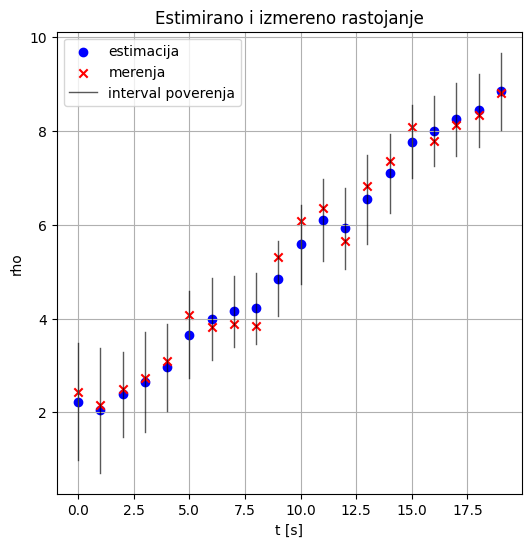

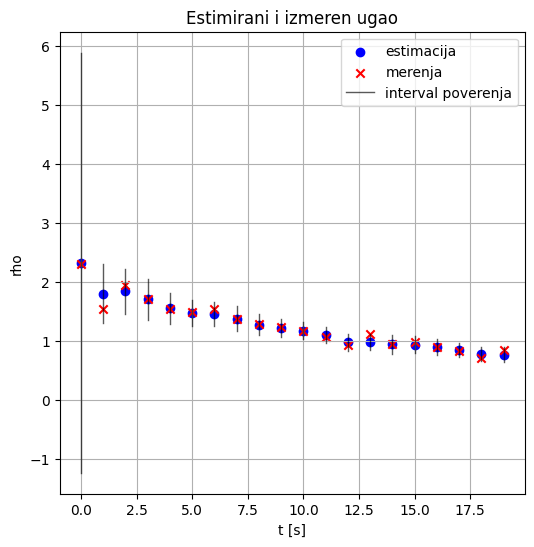

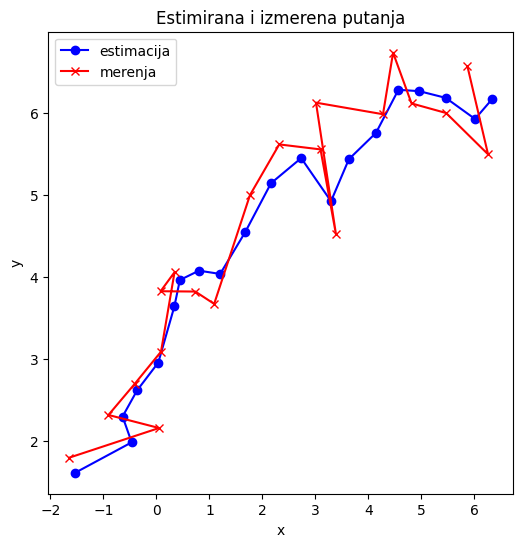

In [10]:
### Prikaz estimiranog i izmerenog rastojanja 
plt.figure(figsize=(6,6))
plt.scatter(t, rho_est, c='b', marker='o')
plt.scatter(t, rho, c='r', marker='x')
for i in range(N_o):
    plt.plot([i, i], [rho_est[i] - 2*rho_std[i], rho_est[i] + 2*rho_std[i]], c='k', linewidth=1, alpha=0.65)
plt.legend(['estimacija','merenja','interval poverenja'])
plt.xlabel('t [s]'); plt.ylabel('rho'); plt.title('Estimirano i izmereno rastojanje')
plt.grid()
plt.show()

### Prikaz estimiranog i izmerenog ugla
plt.figure(figsize=(6,6))
plt.scatter(t, theta_est, c='b', marker='o')
plt.scatter(t, theta, c='r', marker='x')
for i in range(N_o):
    plt.plot([i, i], [theta_est[i] - 2*theta_std[i], theta_est[i] + 2*theta_std[i]], c='k', linewidth=1, alpha=0.65)
plt.legend(['estimacija','merenja','interval poverenja'])
plt.xlabel('t [s]'); plt.ylabel('rho'); plt.title('Estimirani i izmeren ugao')
plt.grid()
plt.show()

### Prikaz estimirane i izmerene putanje
plt.figure(figsize=(6,6))
plt.plot(est_trajectory[0,:], est_trajectory[1,:], c='b', marker='o', label='estimacija')
plt.plot(rho*np.cos(theta), rho*np.sin(theta), c='r', marker='x', label='merenja')
plt.legend()
plt.xlabel('x'); plt.ylabel('y'); plt.title('Estimirana i izmerena putanja')
plt.show()